Take Home Assignment - Credit Risk Model

##### Problem statement: 
The problem statement is "to use this dataset to produce the best credit scoring model that you can build. We are looking for a model that outputs probability estimates as opposed to reliable predictions."


#### 1) Introduction
I would address this problem through 4 steps: 1) Problem statement setup, 2) Data exploration analysis and feature generation, 3) model building and performance evaluation.

#### 2) Problem statement set up
The goal of the assignment is to build a credit risk model from the dataset. A credit risk score is a numerical value that represents the creditworthiness of an individual or an entity. It is a measure of the likelihood that a borrower will default on a loan or other credit obligations. Credit risk scores are typically calculated using information from a person's credit report. Lenders and other financial institutions use credit risk scores to assess the risk of lending money to a borrower and to determine the interest rate and other terms of the loan.

In this problem, I will build a logistic regression model to predict the probability of default. This is because logistic regression is the tried and true method in credit risk modeling for the past few decades. The logistic regression model is the most common way to build a credit risk model because 1) it is easily interpretable. The relationship between an independent variable and the target can be reflected through the regression coefficient, 2) it provides a simple linear relationship: the relationship between variables is linear, 3) it gives probabilities of default, 4) it is a fast algorithm that can easily support real-time inferencing, 5) it is a standard for auditing. In the financial industry, lending decisions are heavily audited. Auditors usually prefer a tried and true method such as logistic regression.

On top of building a logistic regression model, I will also build a random forest model as a benchmark to compare against the logistics regression model result.


#### 3) Data exploration analysis and feature generation through WoE

Data Exploration Analysis consist of 2 parts: 1) data validation and univariate analysis, 2) bi-variate analysis. 

##### 3.1  Data validation and univariate analysis

From the .info(), .describe() and .unique(), I don't see any apparent data issues. I have the following insights from the exploration: 
1) I assume the target column is "GoodCustomer". It is using 1 and -1 instead of the conventional 1 and 0 values.
2) Most of the features are binary (2 unique values) and some features have very few positive cases. For example, the "foreign worker" field only contains 37 or 3.7% positive cases. It might not have a big impact on the target
3) The max loan amount is 18424, which is a lot higher than the mean of 3271. The distribution is right-skewed.
4) loan duration has a max of 72 months (6 years) and a minimum of 4 months (I assume the unit is in months).
5) 91% of the customers have missed payments. I suspect that the customers are mostly subprime.
6) OtherLoansAtStore feature has 0 variance and the data is all 0. We can drop this.

From the histogram and boxplot, I find the following insights:
1) Age, loan amount, and loan duration are right-skewed. 
2) For the loan duration, there is a huge drop in customer volume after month 24. I suspect that the standard loan duration is 24 months. However, few people are extending the loan after 24 months.

##### 3.2  Bivariate analysis

I plot each feature against the target feature with a "bar line" graph. This gives a better sense of how each independent feature correlate with the target. I found that a few features are not trending monotonic with the PD rate. For example, age, number of other loans show reverse trends. I think part of the reason is due to low volume in some segments. We would need to do an analysis with Weight of Evidence (WOE) and combine some of the groups later on.

I also produce the correlation matrix for all pairs of features. This could tell us if there are any highly correlated features.

##### 3.3 feature creation using WoE and one hot encoding

First of all, it is important to do the feature generation and analysis using only the training data from this point on. This is because we don't want to have feature leakage issues where we are using testing data information in the feature development. Here is breakdown the dataset into 80% training and 20% testing.

Weight of Evidence is a common technique used in logistics regression and specifically in credit risk modeling. In my experience in building risk score models at Capital One and Amazon, we used WoE to discretize continuous features into different bins. The benefit of this is widely discussed in different papers and blogs [1]. I will not repeat it here.

Based on the data exploration and initial WoE assessment, I have grouped the following features into separate bins: 1. age group, 2. loan duration, 3. loan amount, 4. LoanRateAsPercentOfIncome, 5. purposeloan.
The rules for grouping based on WoE are: 1) Each bin should have at least 5% of the observations, 2) Each bin should be non-zero for both good and bad loans, and 3) The WOE should be distinct for each category. Similar groups should be aggregated or binned together. It is because the bins with similar WoE have almost the same proportion of good or bad loans, implying the same predictive power, 4) The WOE should be monotonic, i.e., either growing or decreasing with the bins. The above rules are well documented in academic literature [2].

Also, I have created dummy features for "purpose of the loan" feature as well. I can either create dummy features or label encoding features. I just use a dummy feature here for simplicity’s sake.

##### 3.4 feature dropping

After binning and creating new features, I would drop features that may have low contribution or highly correlate with other features (multicollinearity). The 3 techniques I used are correlation matrix, VIF (variance inflation factor), and Information Value (IV). The correlation matrix checks all pairs of features and outputs the correlation values. The VIF checks whether a feature has high relations with other features in the data. It is recommended to remove any features with VIF>10. Information value is a way to check how much contribution each independent feature has on the target. It is recommended to remove features with <0.02 (YearsAtCurrentHome, NumberOfLiableIndividuals, HasGuarantor, MissedPayments, Unemployed, age_group).

Depending on the model methodology you used, sometimes you don't need to perform this step. For example, Ensemble tree methods are usually good at dealing with highly correlated features. Also, if we build the logistic regression with regularization, the L1 penalty can take care of the highly correlated features as well.

#### 4) Model building and performance evaluation

##### 4.1 Model building with Logistics regression and Random Forest

After step 3, I start building the model by using 5-fold cross-validation with grid search on the best hyper-parameters on the training data. The hyperparameters for logistic regression are C and penalty. C is the inverse of regularization, the larger the C, the smaller is regularization, which means that the algorithm is more prone to overfit the data. Penalty/regularization for L1 (absolute error) and L2 (square error) are also used to reduce overfitting. 

For random forests, I also did a 5-fold cross-validation and select the best hyperparameters. For random forests, I used the number of trees, max depth, and max feature to tune the model.

I am using the F1 score as the evaluation criterion. This is because, for the PD model, the false negative and false positive are more important for these defaulted cases. The F1 score is calculated using precision-recall which is a better indicator.

The cross-validation function will average the F1 score across the 5-fold cross-validation result and I will pick the best hyper-parameters based on the grid search.

Also, the 5-fold cross-validation result includes the variance of the score as well. It can tell us how stable the performance is by checking all the performance outputs.


##### 4.2 Model Performance Evaluation

After choosing the best hyperparameters for Logistic and Random Forest classifier from the training data using 5-fold cross-validation, I conduct the scoring on the holdout test dataset which generates the probability of default for every record. I plotted the PRAUC and ROC curve. The PRAUC score for logistics regression is 0.612 and the random forest is 0.61. It is found that the logistics regression has a slightly higher PRAUC score.
Next, we want to compare the Precision-Recall number. Since this is a binary classification problem, there are infinite number of threshold we can pick to evaluate its precision recall. We usually need to pick a specific threshold to decide whether we want to lend money to a customer or not and we will measure that PR performance. However, this is a more complicated task as most of the companies would use the probability score to determine lending decisions and the loan amount as well. 
To simplify the calculation, if we know the cost of false negative and false positive (or simply the ratio), then we can derive the breakeven point where we can decline all customer loan applications when the probability of default is greater than x. For example, if we know that the cost of a false negative is 50% higher than the cost of a false positive, we could calculate the breakeven point. With a precision of 40% (60% false positive) threshold, we are reaching the breakeven (60/40=1.5). If we are rejecting every customer at the 40% precision threshold, we will not make or lose any money. For the threshold below this, we will be making a positive ROI. Using this assumption, we can evaluate the performance at the precision of 40% as the cut-off. The logistic regression's recall is 90% (we will be able to reject 90% of all bad customers when the threshold is greater than this). 
In reality, we would need to calculate the potential net profit for the decision threshold by incorporating more information such as interest rate, churn rate, earning at default, and probability of default. By using the detailed cost and revenue information, we would be able to draw a better score threshold for evaluation.

##### 4.3 Convert probability score to score card
Industry practice such as FICO is to convert the probability of being a good customer to a score card [3]. A common way is do it through points double odds with a base score of 600 points corresponds to good/bad odds of 50 to 1 and an increase of the score of 20 points corresponds to a doubling of the good/bad odds. I have also converted the test data probability of good customer score to the points double odds score.


### 5 Questions:

1. How reliable are your probability estimates? Pls specify AUC, precision & recall

The model was evaluated through 5-fold cross validation on the training set and also on the holdout test set. I plotted the PRAUC and ROC curve. The PRAUC score for logistics regression is 0.612 and the random forest is 0.61. It is found that the logistics regression has a slightly higher PRAUC score. For precision and recall, I will check the recall at precision equal to 40% as a threshold, which is 90%. In reality, we would need to check various thresholds for precision and recall because we could have different interest rate loans for different customer risk levels.

I have also built a RF model as a benchmark comparison to the logistic regression model.

2. Are there any other features or data sources (not in the dataset) that could help to improve the model further?

There are other features such as: 
1. Credit history: Information on an individual's credit history, including credit accounts, payment history, and credit utilization.
2. Public records: Information from public records such as bankruptcies, tax liens, and judgments.
3. Identity verification: Individual's identity from personal information such as name, address, and social security number.
4. Employment history: Information on an individual's employment history and income, which can be used to assess their ability to make payments.
5. Inquiries: Information on inquiries made on an individual's credit report, which can be used to assess their credit-seeking behavior.
6. Alternative data: Alternative data such as rental payments, utility payments, and payday loans to supplement traditional credit data.
These data can be purchased from Transunion or Equifax.


3. How did you tune the parameters in building your model?

I tuned the model using 5-fold cross-validation with grid search. The evaluation criteria are F1 score. 
If you care more about the false negative and false positive, then use the F1 score. If you care more about the true positive and true negative, use accuracy.
Also, usually defaul is a rare event, so accuracy would not be a good metric. However, in this dataset, over 30% of customers are bad customers, so it is not a problem.


4. Justify the setup you used to validate your model.

There are two ways I validate my model. The first is through the 5-fold cross-validation where the model is built 5 times using 4/5 of the training data and tested on 1/5 of the remaining samples. I can evaluate the average F1 or accuracy score and also the variance of the score.
The second way is through the holdout test set. This is the 20% of data that was not used in the training set. It is used to test the performance of the final model that was built using 100% of the training data.


## Appendix

[1] why do we need to do binning through Weight of Evidence: https://stats.stackexchange.com/questions/567489/why-is-binning-weight-of-evidence-and-information-value-so-ubiquitous-in-the-cr

[2] Thomas, L., Edelman, D. & Crook, J. (2002). Credit Scoring and its Applications.

[3] convert probability score to score card through points to double odds. https://documentation.sas.com/doc/en/emref/14.3/n181vl3wdwn89mn1pfpqm3w6oaz5.htm



In [16]:
#import relevant library
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.special import logit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [17]:
# read the data file in as dataframe
df = pd.read_csv("german_processed.csv")

In [18]:
# check top 5 and bottom 5 records
df.head()


,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,M,0,1,67,6,Electronics,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,-1,F,0,0,22,48,Electronics,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,M,0,1,49,12,Education,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,1,M,0,1,45,42,Furniture,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,-1,M,0,1,53,24,NewCar,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
# check colomn data type and verify if there are any mismatches. 
# check if there are any nulls in the data features.

# the data types match with the data and there is no nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   GoodCustomer                     1000 non-null   int64 
 1   Gender                           1000 non-null   object
 2   ForeignWorker                    1000 non-null   int64 
 3   Single                           1000 non-null   int64 
 4   Age                              1000 non-null   int64 
 5   LoanDuration                     1000 non-null   int64 
 6   PurposeOfLoan                    1000 non-null   object
 7   LoanAmount                       1000 non-null   int64 
 8   LoanRateAsPercentOfIncome        1000 non-null   int64 
 9   YearsAtCurrentHome               1000 non-null   int64 
 10  NumberOfOtherLoansAtBank         1000 non-null   int64 
 11  NumberOfLiableIndividuals        1000 non-null   int64 
 12  HasTelephone                     10

In [12]:
# check basic data distributions, central tendancy for all features

# insights: 
# 1) target column "GoodCustomer" is using 1 and -1 instead of the conventional 1 and 0.
# 2) foreign worker, only 37 or 3.7% of the customers are foreign workers. It might not have a big impact on the target
# 3) max loan amount is 18424, it is a lot higher than the mean of 3271.
# 4) loan duration has a max of 72 months (6 years)
# 5) 91% of the customers have missed payments (suspect that the file contains mostly subprime customers)
# 6) OtherLoansAtStore has 0 variance and data is all 0. We can drop this.
df.describe()

,GoodCustomer,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.400000,0.037000,0.54800,35.546000,20.903000,3271.258000,2.973000,2.845000,1.407000,1.155000,0.404000,0.332000,0.063000,0.214000,0.111000,0.912000,0.049000,0.293000,0.13900,0.0,0.041000,0.052000,0.713000,0.179000,0.062000,0.172000,0.42700,0.778000
std,0.916974,0.188856,0.49794,11.375469,12.058814,2822.736876,1.118715,1.103718,0.577654,0.362086,0.490943,0.471167,0.243085,0.410332,0.314289,0.283437,0.215976,0.455366,0.34612,0.0,0.198389,0.222138,0.452588,0.383544,0.241276,0.377569,0.49489,0.415799
min,-1.000000,0.000000,0.00000,19.000000,4.000000,250.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-1.000000,0.000000,0.00000,27.000000,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,1.000000,0.000000,1.00000,33.000000,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.000000,0.000000,1.00000,42.000000,24.000000,3972.250000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
max,1.000000,1.000000,1.00000,75.000000,72.000000,18424.000000,4.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [23]:
# check how many unique values are there in each feature
# we can see that majority of the features are binary. The ones that are not are age, loan duration, loan purpose
# loan amount, percent of income, year at current home and number of other loans at Bank
df.nunique()


GoodCustomer                         2
Gender                               2
ForeignWorker                        2
Single                               2
Age                                 53
LoanDuration                        33
PurposeOfLoan                       10
LoanAmount                         921
LoanRateAsPercentOfIncome            4
YearsAtCurrentHome                   4
NumberOfOtherLoansAtBank             4
NumberOfLiableIndividuals            2
HasTelephone                         2
CheckingAccountBalance_geq_0         2
CheckingAccountBalance_geq_200       2
SavingsAccountBalance_geq_100        2
SavingsAccountBalance_geq_500        2
MissedPayments                       2
NoCurrentLoan                        2
CriticalAccountOrLoansElsewhere      2
OtherLoansAtBank                     2
OtherLoansAtStore                    1
HasCoapplicant                       2
HasGuarantor                         2
OwnsHouse                            2
RentsHouse               

In [38]:
# drop the OtherLoansAtStore column since it has single value 0
df.drop ('OtherLoansAtStore', axis=1, inplace=True)

# replace target column -1 to the more conventional 0
df['GoodCustomer'].replace (-1, 0, inplace=True)

In [39]:
# check what percentage of customers are good
# this is not a rare event problem since we have 30% of bad customers. 
# we don't need to down sample or up sample when we build the model
sum(df['GoodCustomer'])/len(df)

0.7

In [15]:
from sklearn.preprocessing import Binarizer
import pandas
import numpy
names_list = ['Alaska', 'Pratyush', 'Pierce', 'Sandra', 'Soundarya', 'Meredith', 'Richard', 'Jackson', 'Tom' ,'Joe']
data_frame = pandas.read_csv(url, names=names_list)
array = dataframe.values
# Splitting the array into input and output 
A = array [: 0:7]
B = array [:7]
binarizer = Binarizer(threshold=0.0). fit(X)
binaryA = binarizer.transform(A)
numpy.set_printoptions(precision=5)
print (binaryA [0:7:])

NameError: name 'url' is not defined

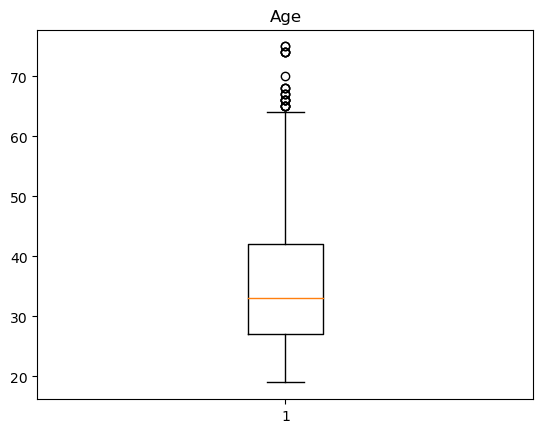

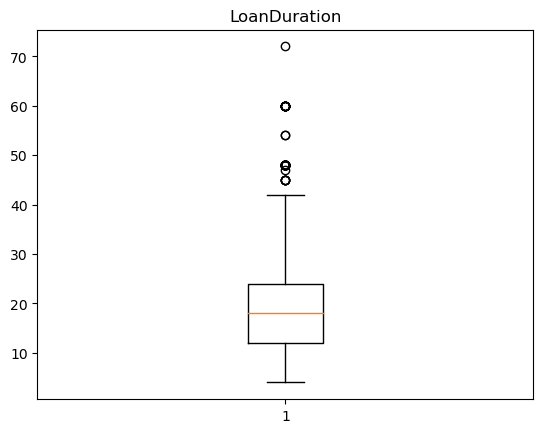

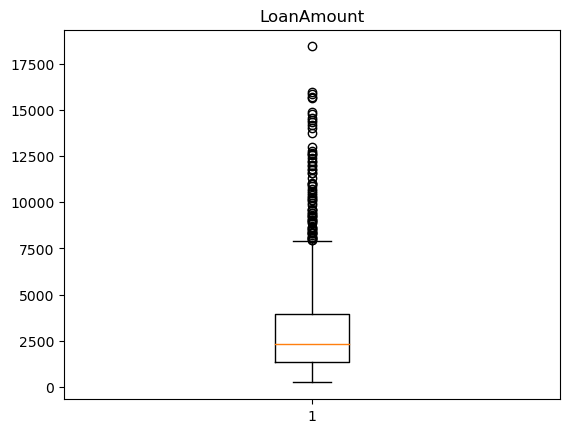

In [47]:
# conduct univariate analysis
# we don't need to check the binary features since we already learn about them in the .describe() function
# in terms of what percentage of the records are 1s. 


continuous_features = ['Age', 'LoanDuration','LoanAmount']

# plot box plot and see how the outliers are like
# Age and loan duration have a couple of outliers. loan amount are long tail
for i in continuous_features:
    plt.boxplot(df[i])
    plt.title(i)
    plt.show()
    



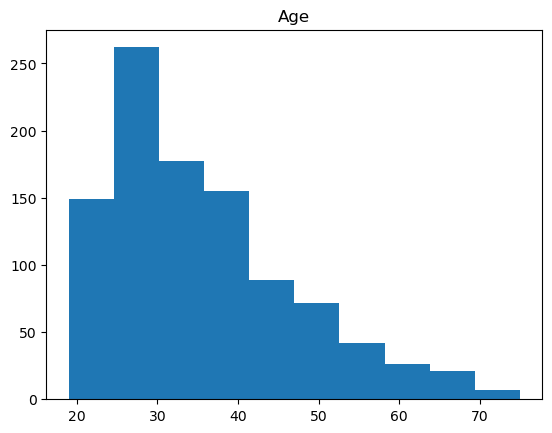

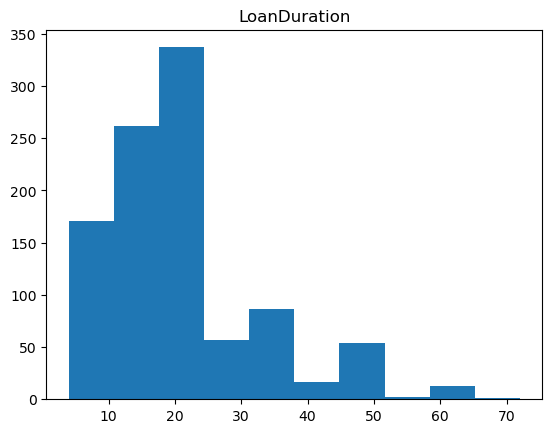

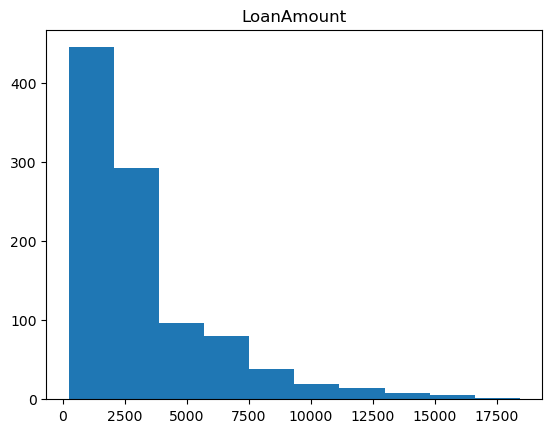

In [48]:
    
# look at the histogram of the 3 continuous variables
# age and loan amount are right skewed which is fine.
# there is a pretty big drop off for loan duration after 20 months. This is quite strange. 
# Maybe it has somemthing to do with the policy? The loan has a 20 months expiration and the rest are people who 
# continue the loan?

for i in continuous_features:
    plt.hist(df[i])
    plt.title(i)
    plt.show()

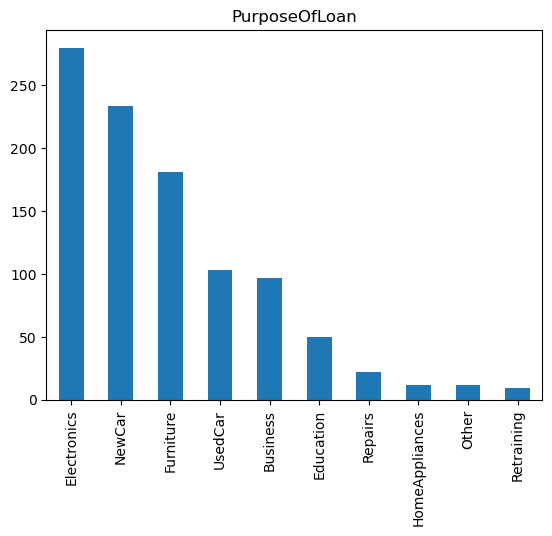

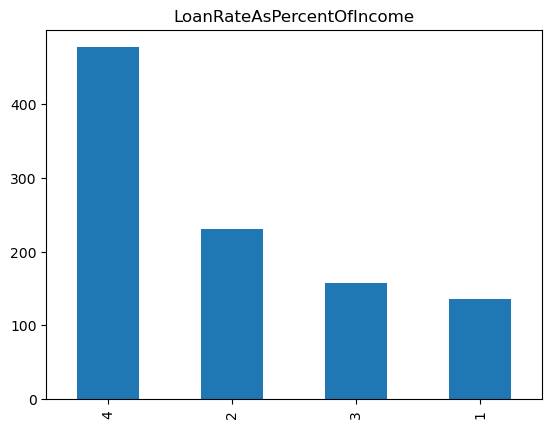

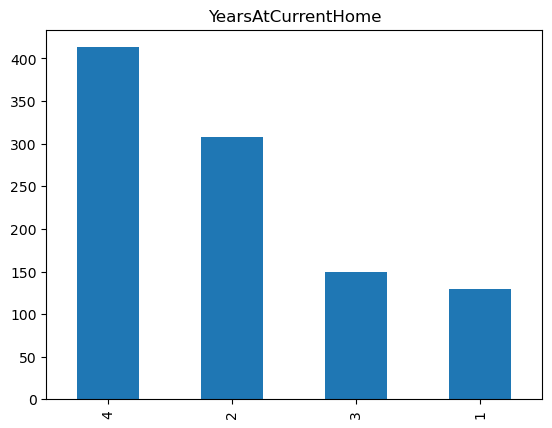

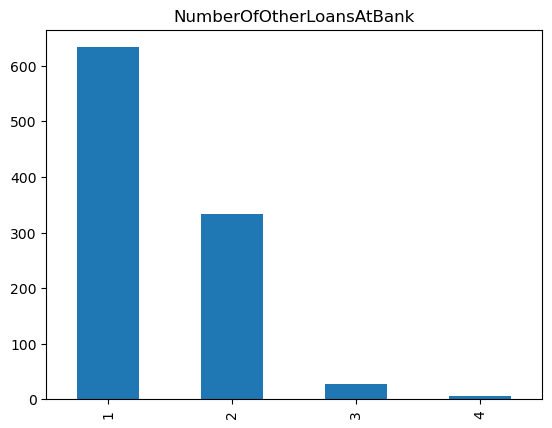

In [50]:

# check other features that have more than 2 levels
cat_features = [ 'PurposeOfLoan', 'LoanRateAsPercentOfIncome','YearsAtCurrentHome', 'NumberOfOtherLoansAtBank']

for i in cat_features:
    df[i].value_counts().plot(kind='bar', title=i)
    plt.show()

In [120]:
# Conduct bivariate anlaysis, check these features and how it relates to target good customer

#This module will plot bivariate analysis
def bi_variate(df,var1,target):
    #get the logit of the ratio
    rate=df.groupby([var1])[target].sum()/df.groupby([var1])[target].count().sort_index()
    vol=df[var1].value_counts().sort_index()
    pl=pd.concat([vol, rate],axis=1)
    print (pl)
    fig = plt.figure()
    ax = pl[var1].plot(kind="bar");
    ax.set_xlabel(var1)
    plt.xticks(rotation=90)
    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(),pl[target],marker='o',color='red')
    plt.title(target + ' by ' + var1)
    ax2.set_ylim(ymin=0)
    plt.show()


   Gender  badcustomer
F     310     0.351613
M     690     0.276812


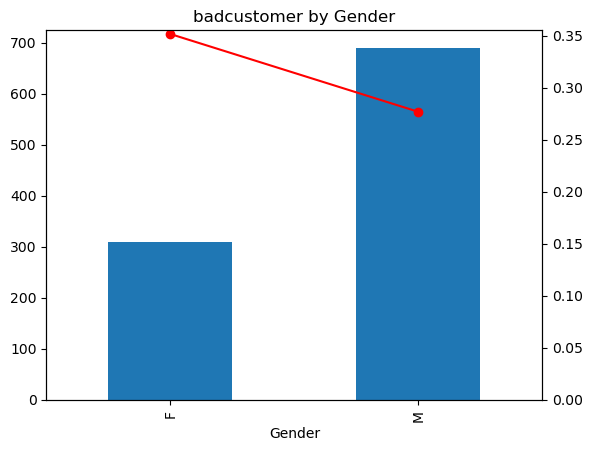

   ForeignWorker  badcustomer
0            963     0.307373
1             37     0.108108


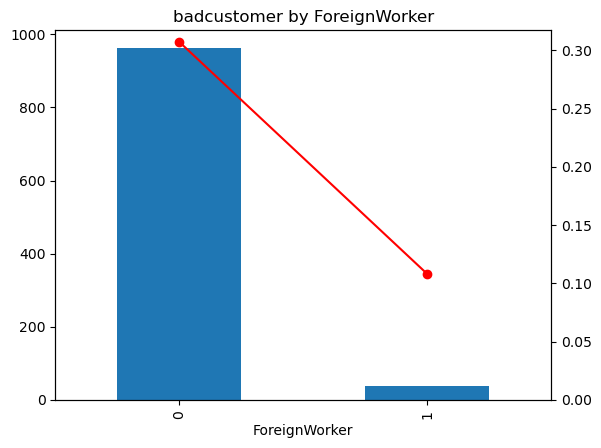

   Single  badcustomer
0     452     0.340708
1     548     0.266423


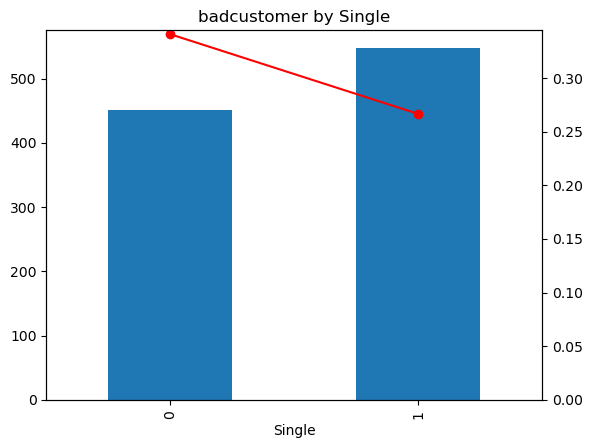

    Age  badcustomer
19    2     0.500000
20   14     0.357143
21   14     0.357143
22   27     0.407407
23   48     0.416667
24   44     0.431818
25   41     0.463415
26   50     0.280000
27   51     0.254902
28   43     0.348837
29   37     0.405405
30   40     0.275000
31   38     0.289474
32   34     0.264706
33   33     0.393939
34   32     0.343750
35   40     0.150000
36   39     0.153846
37   29     0.275862
38   24     0.166667
39   21     0.285714
40   25     0.240000
41   17     0.235294
42   22     0.363636
43   17     0.294118
44   17     0.294118
45   15     0.200000
46   18     0.222222
47   17     0.294118
48   12     0.250000
49   14     0.071429
50   12     0.250000
51    8     0.125000
52    9     0.111111
53    7     0.714286
54   10     0.200000
55    8     0.375000
56    3     0.000000
57    9     0.333333
58    5     0.400000
59    3     0.333333
60    6     0.500000
61    7     0.428571
62    2     0.000000
63    8     0.125000
64    5     0.000000
65    5     0

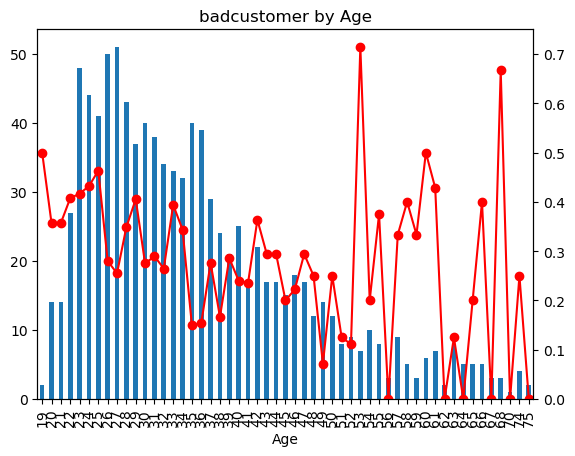

    LoanDuration  badcustomer
4              6     0.000000
5              1     0.000000
6             75     0.120000
7              5     0.000000
8              7     0.142857
9             49     0.285714
10            28     0.107143
11             9     0.000000
12           179     0.273743
13             4     0.000000
14             4     0.250000
15            64     0.187500
16             2     0.500000
18           113     0.371681
20             8     0.125000
21            30     0.300000
22             2     0.000000
24           184     0.304348
26             1     0.000000
27            13     0.384615
28             3     0.333333
30            40     0.325000
33             3     0.333333
36            83     0.445783
39             5     0.200000
40             1     1.000000
42            11     0.272727
45             5     0.800000
47             1     0.000000
48            48     0.583333
54             2     0.500000
60            13     0.461538
72        

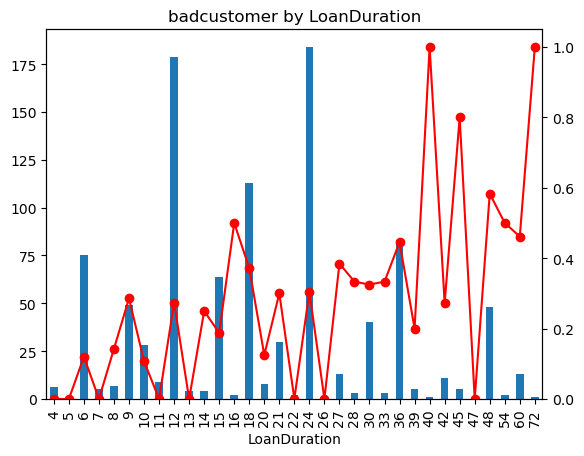

                PurposeOfLoan  badcustomer
Business                   97     0.350515
Education                  50     0.440000
Electronics               280     0.221429
Furniture                 181     0.320442
HomeAppliances             12     0.333333
NewCar                    234     0.380342
Other                      12     0.416667
Repairs                    22     0.363636
Retraining                  9     0.111111
UsedCar                   103     0.165049


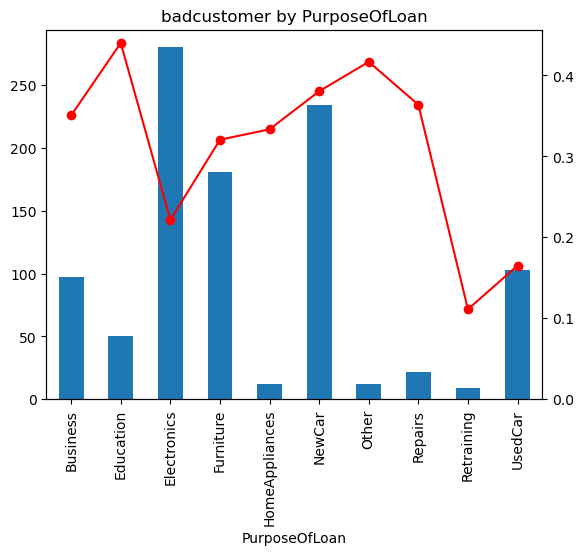

       LoanAmount  badcustomer
250             1          0.0
276             1          0.0
338             1          0.0
339             1          0.0
343             1          0.0
...           ...          ...
15653           1          0.0
15672           1          1.0
15857           1          0.0
15945           1          1.0
18424           1          1.0

[921 rows x 2 columns]


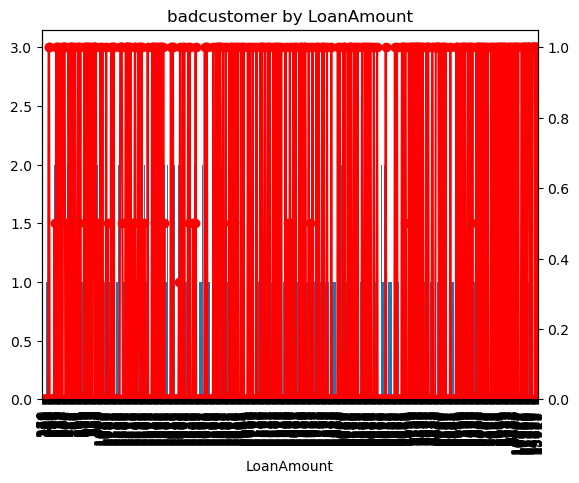

   LoanRateAsPercentOfIncome  badcustomer
1                        136     0.250000
2                        231     0.268398
3                        157     0.286624
4                        476     0.334034


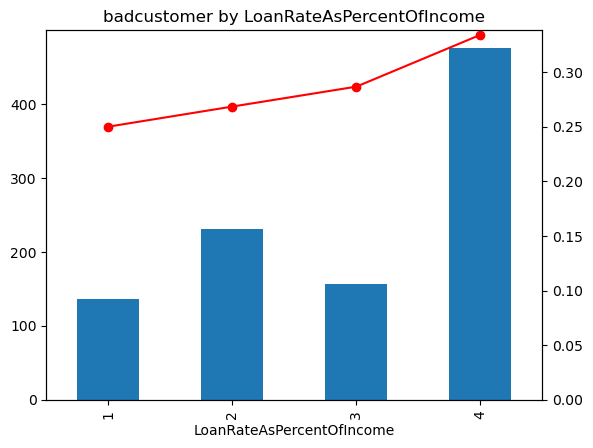

   YearsAtCurrentHome  badcustomer
1                 130     0.276923
2                 308     0.314935
3                 149     0.288591
4                 413     0.300242


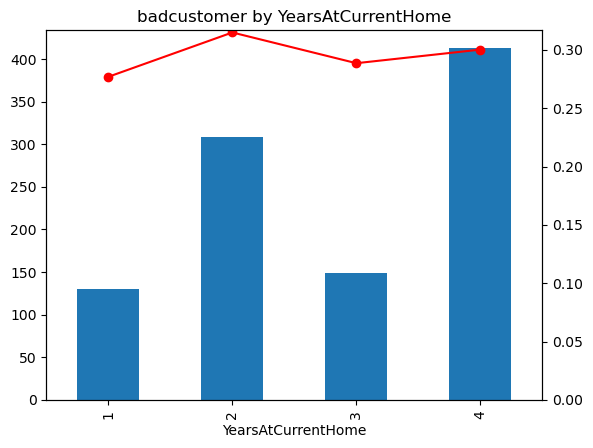

   NumberOfOtherLoansAtBank  badcustomer
1                       633     0.315956
2                       333     0.276276
3                        28     0.214286
4                         6     0.333333


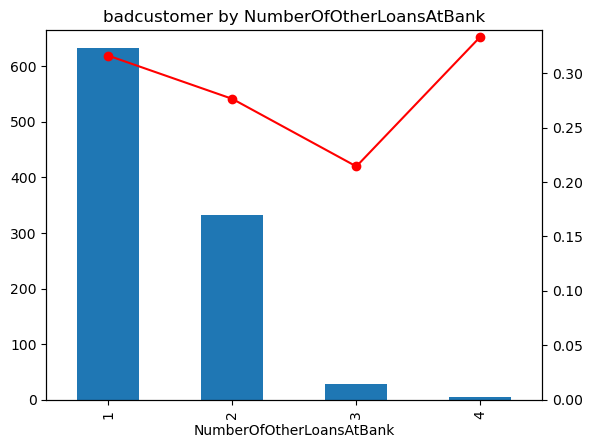

   NumberOfLiableIndividuals  badcustomer
1                        845     0.300592
2                        155     0.296774


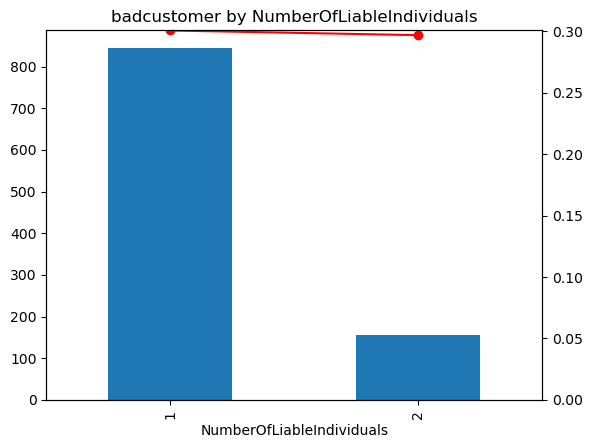

   HasTelephone  badcustomer
0           596     0.313758
1           404     0.279703


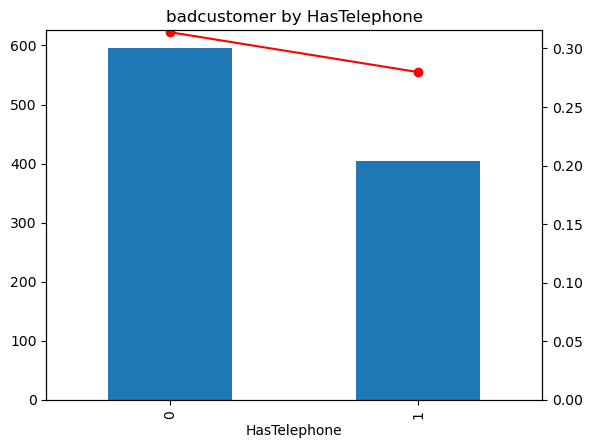

   CheckingAccountBalance_geq_0  badcustomer
0                           668     0.270958
1                           332     0.358434


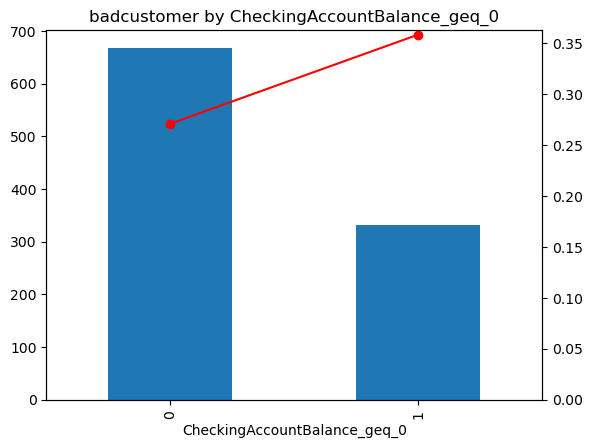

   CheckingAccountBalance_geq_200  badcustomer
0                             937     0.305229
1                              63     0.222222


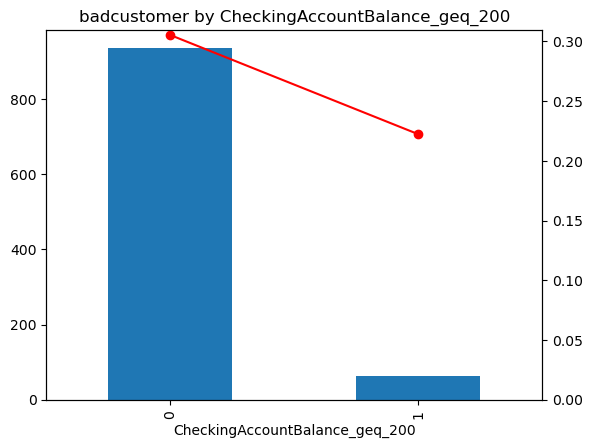

   SavingsAccountBalance_geq_100  badcustomer
0                            786     0.316794
1                            214     0.238318


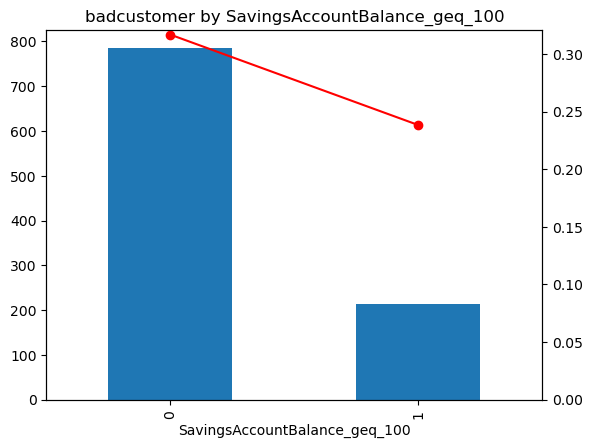

   SavingsAccountBalance_geq_500  badcustomer
0                            889     0.318335
1                            111     0.153153


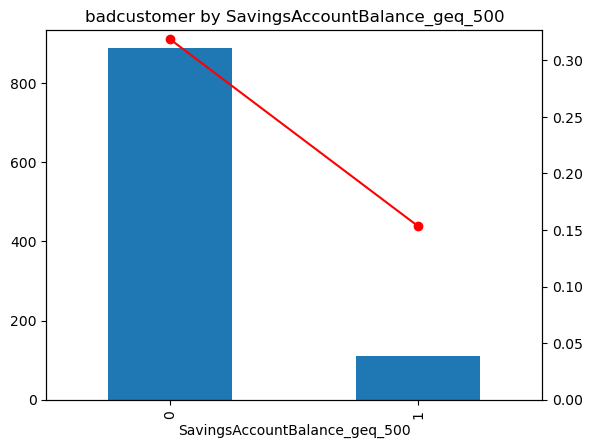

   MissedPayments  badcustomer
0              88     0.318182
1             912     0.298246


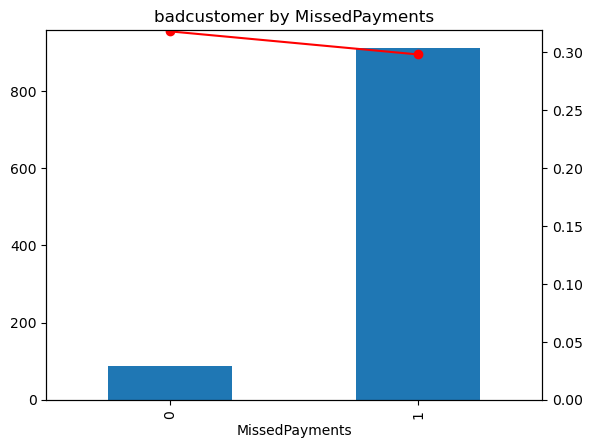

   NoCurrentLoan  badcustomer
0            951     0.286015
1             49     0.571429


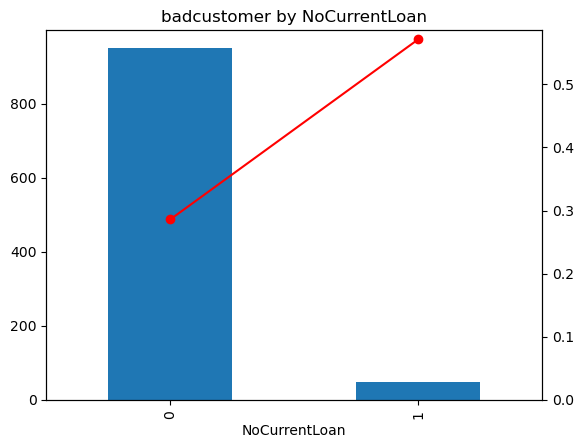

   CriticalAccountOrLoansElsewhere  badcustomer
0                              707     0.353607
1                              293     0.170648


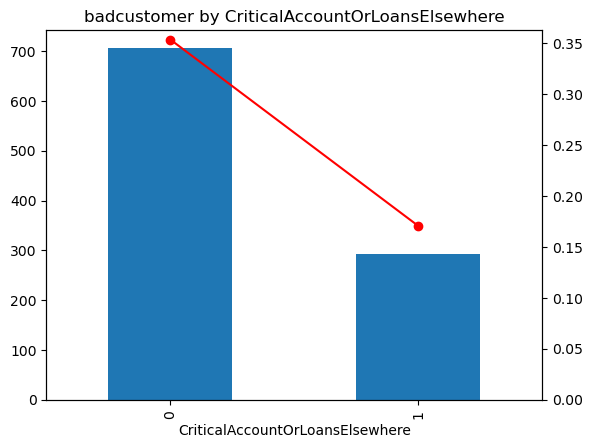

   OtherLoansAtBank  badcustomer
0               861     0.282230
1               139     0.410072


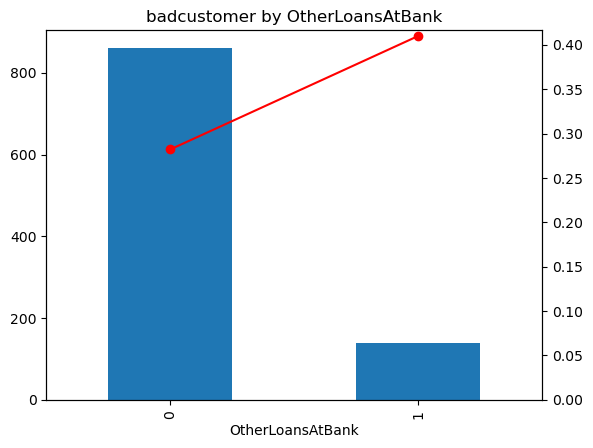

   HasCoapplicant  badcustomer
0             959     0.294056
1              41     0.439024


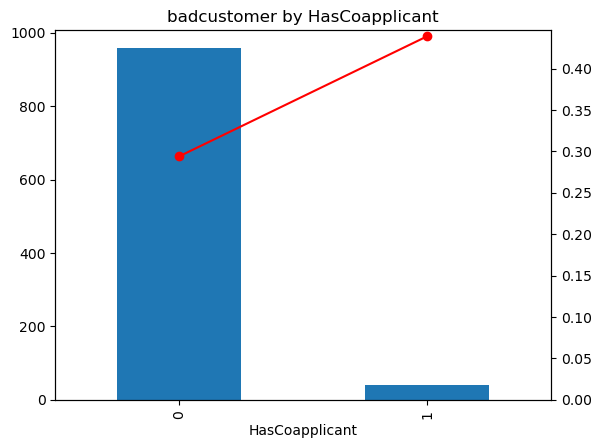

   HasGuarantor  badcustomer
0           948     0.305907
1            52     0.192308


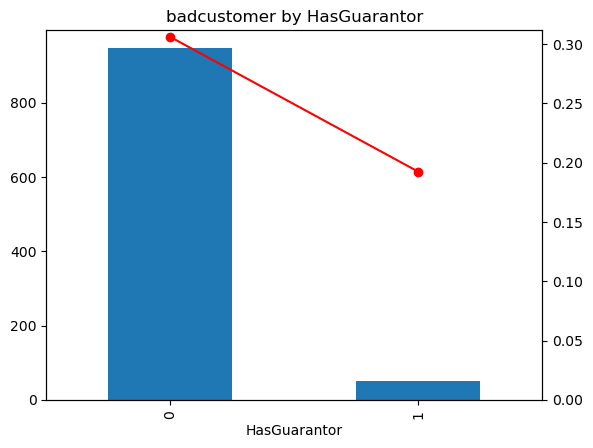

   OwnsHouse  badcustomer
0        287     0.397213
1        713     0.260870


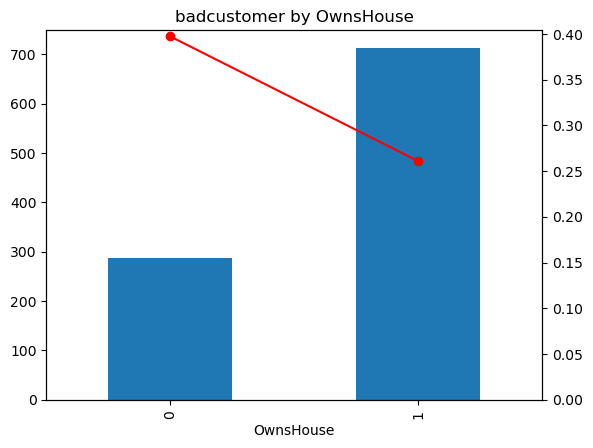

   RentsHouse  badcustomer
0         821     0.280146
1         179     0.391061


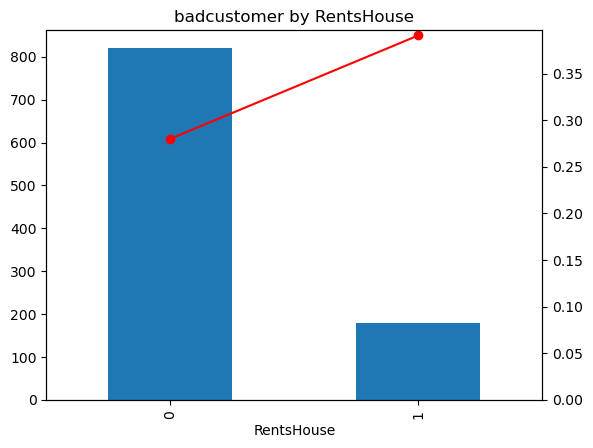

   Unemployed  badcustomer
0         938     0.295309
1          62     0.370968


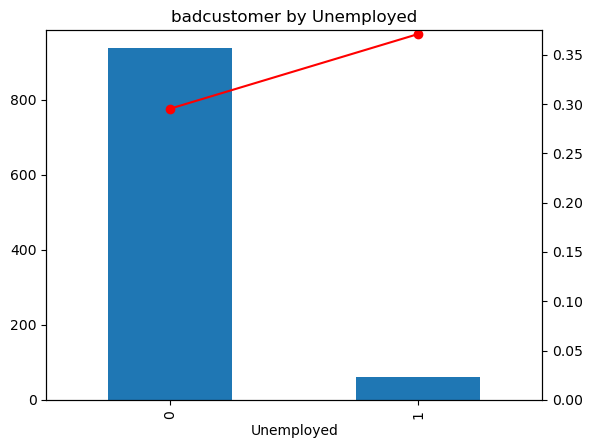

   YearsAtCurrentJob_lt_1  badcustomer
0                     828     0.277778
1                     172     0.406977


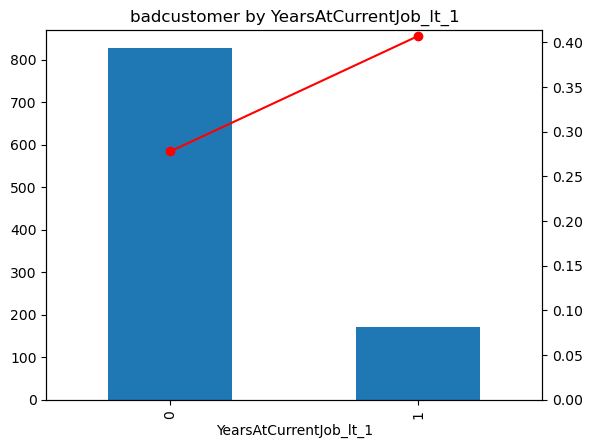

   YearsAtCurrentJob_geq_4  badcustomer
0                      573     0.343805
1                      427     0.241218


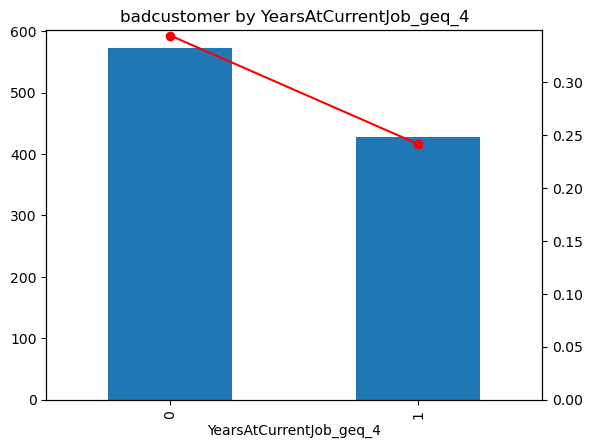

   JobClassIsSkilled  badcustomer
0                222     0.283784
1                778     0.304627


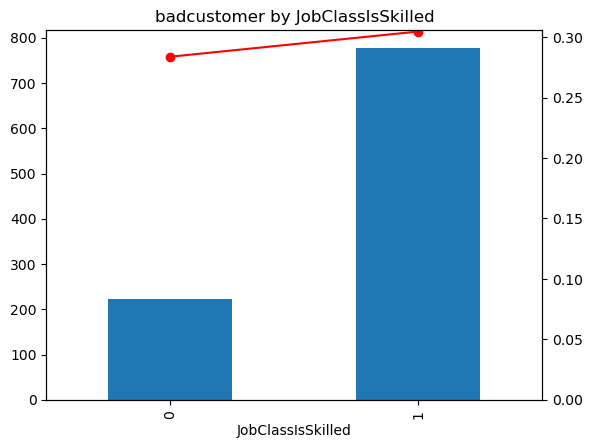

In [58]:
# create a new feature for target
df['badcustomer']=1-df['GoodCustomer']

# NumberOfOtherLoansAtBank shows a non monotonic trend at value 4. However, the bad rate
# is not representative because the volume is small - with only 6 customers. We can bin it together with 3.

# Also, we should bin the age, loan duration and loan amount.
for i in df.columns:
    if i != 'GoodCustomer' and i!= 'badcustomer':
        bi_variate(df, i, 'badcustomer')

<AxesSubplot:>

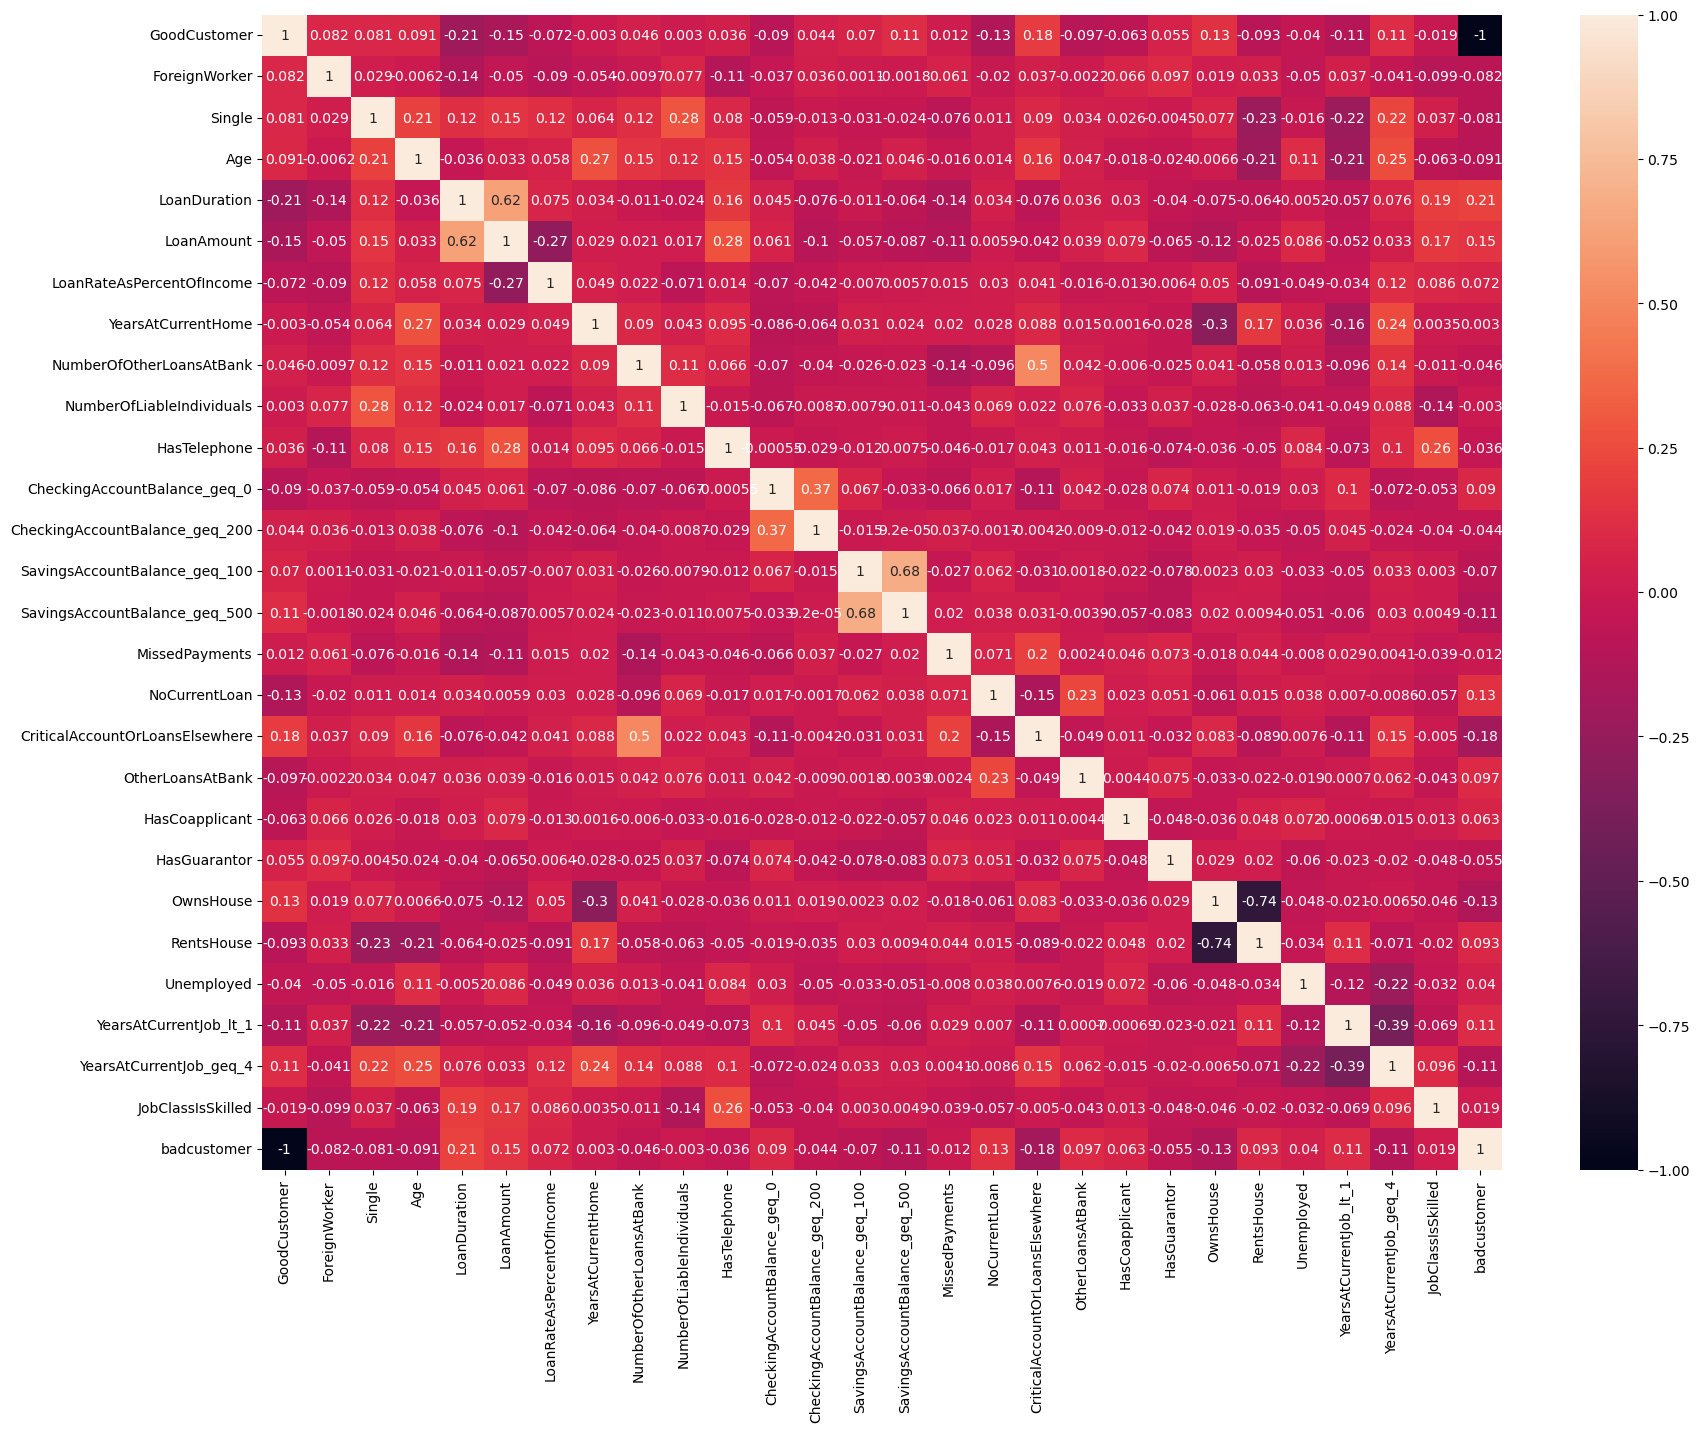

In [77]:
#create seaborn heatmap for correlation matrix
fig, ax = plt.subplots(figsize=(20, 15))
sb.heatmap(df.corr(), annot=True)

In [81]:
# doing some sanity check on the highest correlation pairs of features
# we should drop some of the highly correclated features to avoid multi-colinearity. 
# We can either do it now or use L1 penalized regression to take care of it later.

df.corr().unstack().sort_values().drop_duplicates()

GoodCustomer                     badcustomer                       -1.000000
RentsHouse                       OwnsHouse                         -0.735968
YearsAtCurrentJob_lt_1           YearsAtCurrentJob_geq_4           -0.393446
YearsAtCurrentHome               OwnsHouse                         -0.297547
LoanAmount                       LoanRateAsPercentOfIncome         -0.271316
RentsHouse                       Single                            -0.225860
YearsAtCurrentJob_lt_1           Single                            -0.224983
Unemployed                       YearsAtCurrentJob_geq_4           -0.221938
LoanDuration                     GoodCustomer                      -0.214927
RentsHouse                       Age                               -0.212620
YearsAtCurrentJob_lt_1           Age                               -0.209967
badcustomer                      CriticalAccountOrLoansElsewhere   -0.181713
YearsAtCurrentHome               YearsAtCurrentJob_lt_1            -0.164155

In [87]:
# create bins for age group
def age_group(x):
    if x<30:
        return 1
    elif x<40:
        return 2
    elif x<50:
        return 3
    elif x<60:
        return 4
    elif x<80:
        return 5

df['age_group']=df['Age'].apply(age_group)

In [88]:
# create bins for loan duration
def loanDur_group(x):
    if x<=12:
        return 1
    elif x<=24:
        return 2
    elif x<=36:
        return 3
    elif x<=48:
        return 4
    elif x<=60:
        return 5
    elif x<=72:
        return 6
    
df['loanDur_group']=df['LoanDuration'].apply(loanDur_group)    


In [157]:
pd.qcut(df.LoanAmount, q=10)

0        (932.0, 1262.0]
1       (4720.0, 7179.4]
2       (1906.8, 2319.5]
3      (7179.4, 18424.0]
4       (4720.0, 7179.4]
             ...        
995     (1479.4, 1906.8]
996     (3590.0, 4720.0]
997     (249.999, 932.0]
998     (1479.4, 1906.8]
999     (3590.0, 4720.0]
Name: LoanAmount, Length: 1000, dtype: category
Categories (10, interval[float64, right]): [(249.999, 932.0] < (932.0, 1262.0] < (1262.0, 1479.4] < (1479.4, 1906.8] ... (2852.4, 3590.0] < (3590.0, 4720.0] < (4720.0, 7179.4] < (7179.4, 18424.0]]

In [277]:
# we need to create some feature binning. However, we should create the bins based only on training data.
# this is because we don't want to have data leakage if we include the entire dataset.

X=df
y=df['badcustomer']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [278]:
# create 10 equal bins for loan amount
x_train['loadAmount_group']=pd.qcut(x_train.LoanAmount, q=10, labels=False, duplicates='drop')


In [432]:


# create WOE and IV calculation module 

def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# features to test on WOE
feature_woe = [ 'ForeignWorker', 'Single', 
       'LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
       'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse',
       'RentsHouse', 'Unemployed', 'YearsAtCurrentJob_lt_1',
       'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled', 
       'age_group', 'loanDur_group', 'loadAmount_group']
# print all WOE and IV values for each feature.
# we can see that some features do not have monotonic WOE and many features come with low IV value, <0.02
for i in feature_woe:
    print (i)
    print( woe_ordered_continuous(x_train, i, x_train['GoodCustomer'])[['WoE','IV']])



ForeignWorker
        WoE        IV
0 -0.030418  0.030723
1  1.012571  0.030723
Single
        WoE        IV
0 -0.152897  0.018411
1  0.120598  0.018411
LoanRateAsPercentOfIncome
        WoE        IV
0  0.287583  0.026969
1  0.079874  0.026969
2  0.140941  0.026969
3 -0.154342  0.026969
YearsAtCurrentHome
        WoE        IV
0  0.043637  0.011683
1 -0.135312  0.011683
2  0.195418  0.011683
3  0.021379  0.011683
NumberOfOtherLoansAtBank
        WoE        IV
0 -0.042619  0.004907
1  0.054389  0.004907
2  0.285901  0.004907
NumberOfLiableIndividuals
        WoE        IV
0 -0.008403  0.000386
1  0.045886  0.000386
HasTelephone
        WoE        IV
0 -0.052755  0.004428
1  0.083967  0.004428
CheckingAccountBalance_geq_0
        WoE        IV
0  0.107136  0.022003
1 -0.205749  0.022003
CheckingAccountBalance_geq_200
        WoE        IV
0 -0.012566  0.002653
1  0.211210  0.002653
SavingsAccountBalance_geq_100
        WoE        IV
0 -0.081798  0.027505
1  0.337020  0.027505
SavingsAcc

   loadAmount_group  badcustomer
0               101     0.306931
1               100     0.300000
2                99     0.262626
3               100     0.220000
4               100     0.300000
5               100     0.240000
6               101     0.227723
7                99     0.292929
8               100     0.380000
9               100     0.470000


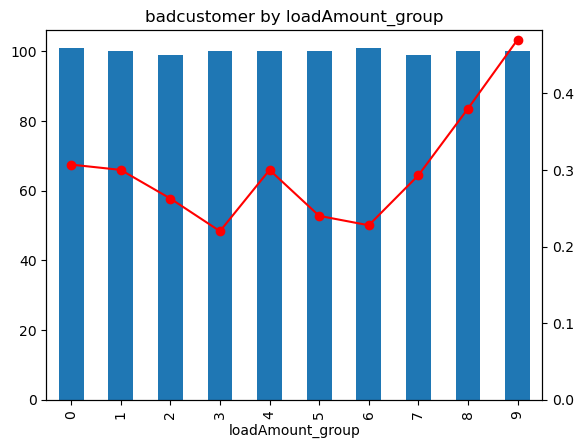

   loanDur_group  badcustomer
1            359     0.211699
2            411     0.296837
3            143     0.398601
4             87     0.517241


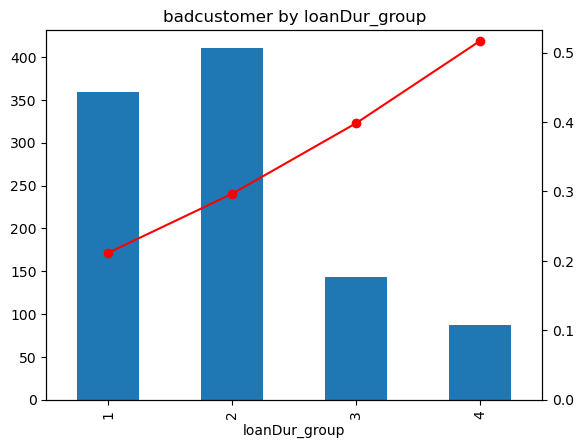

   age_group  badcustomer
1        371     0.369272
2        629     0.259141


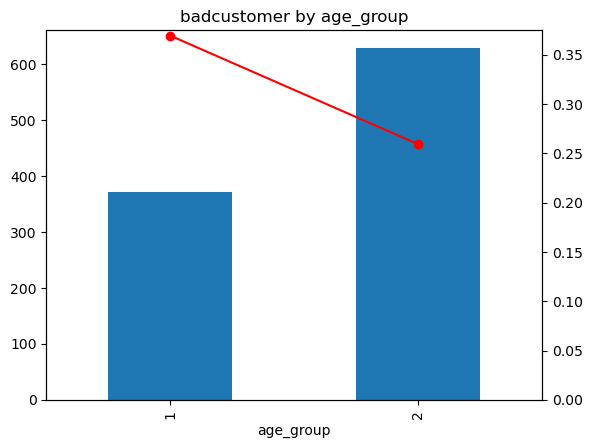

   LoanRateAsPercentOfIncome  badcustomer
1                        136     0.250000
2                        231     0.268398
3                        157     0.286624
4                        476     0.334034


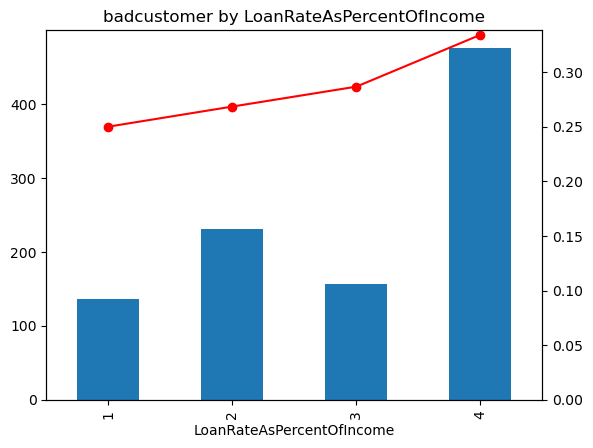

In [433]:
# check bivariate charts for the 3 groups
fea=['loadAmount_group', 'loanDur_group', 'age_group', 'LoanRateAsPercentOfIncome']

for i in fea:
    bi_variate(df, i, 'badcustomer')
    
# based on the charts, I found that 
# 1) loan amount has monotonic relationship after $2800 dollars,
# we would need to create 4 buckets instead of 10 buckets otherwise it wouldn't be monotonic increasing/decreasing

# 2) loan duration group 5 and 6 have very low volume, we should combine it with group 4

# 3) age is a good predictor only for the younger age group (<30 years old). We can create two groups for age

In [279]:
def age_group(x):
    if x<30:
        return 1
    else:
        return 2

df['age_group']=df['Age'].apply(age_group)
x_train['age_group']=x_train['Age'].apply(age_group)
x_test['age_group']=x_test['Age'].apply(age_group)

In [280]:
def loanDur_group(x):
    if x<=12:
        return 1
    elif x<=24:
        return 2
    elif x<=36:
        return 3
    elif x<=72:
        return 4
    
df['loanDur_group']=df['LoanDuration'].apply(loanDur_group)    
x_train['loanDur_group']=x_train['LoanDuration'].apply(loanDur_group)
x_test['loanDur_group']=x_test['LoanDuration'].apply(loanDur_group)

In [281]:
# based on qcut, the bivariate chart and WOE, I chose the group it in the following way to make sure the resulting 
# WoE is monotonic and has a stepwise change between bins.

def loanamountGroup(x):
    if x<=3000:
        return 1
    elif x<=5000:
        return 2
    elif x<=7000:
        return 3
    else:
        return 4
x_train['loanamount_group']=x_train['LoanAmount'].apply(loanamountGroup)
x_test['loanamount_group']=x_test['LoanAmount'].apply(loanamountGroup)

In [456]:
# bin the group based on WOE and bivariate data
def LoanRateAsPercentOfIncomeGroup(x):
    if x==3:
        return 2
    elif x==4:
        return 3
    else:
        return x
x_train['LoanRateAsPercentOfIncome_group']=x_train['LoanRateAsPercentOfIncome'].apply(LoanRateAsPercentOfIncomeGroup)
x_test['LoanRateAsPercentOfIncome_group']=x_test['LoanRateAsPercentOfIncome'].apply(LoanRateAsPercentOfIncomeGroup)

   loadAmount_group  badcustomer
0                80       0.3375
1                80       0.2875
2                80       0.2625
3                80       0.2125
4                80       0.2875
5                80       0.2750
6                80       0.2375
7                80       0.2750
8                80       0.3500
9                80       0.4500


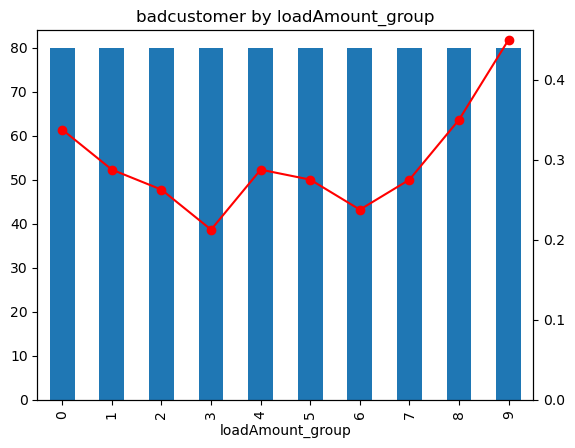

   loanDur_group  badcustomer
1            280     0.210714
2            335     0.304478
3            115     0.391304
4             70     0.457143


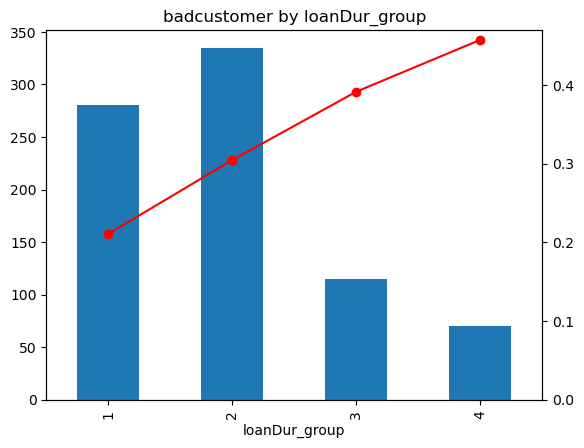

   age_group  badcustomer
1        303     0.366337
2        497     0.255533


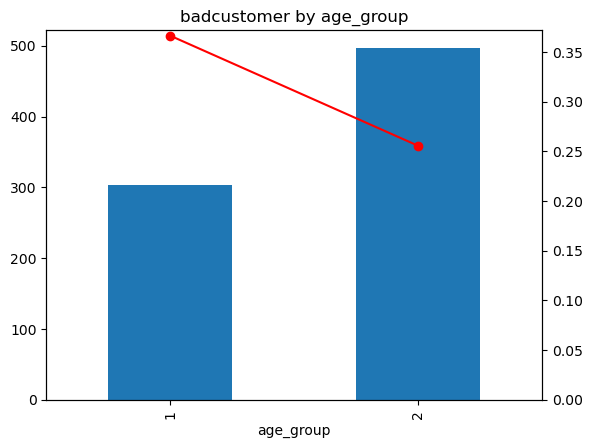

                       PurposeOfLoan  badcustomer
Electronics                      230     0.226087
Furn|Rep|HomeApp|buss            244     0.327869
NewC|Ed                          229     0.379913
Other                              9     0.444444
Retrain|UsedC                     88     0.170455


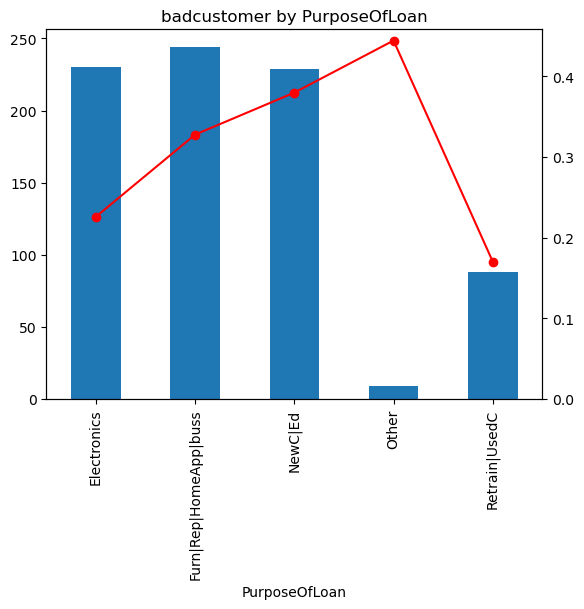

   LoanRateAsPercentOfIncome_group  badcustomer
1                              112     0.241071
2                              304     0.276316
3                              384     0.330729


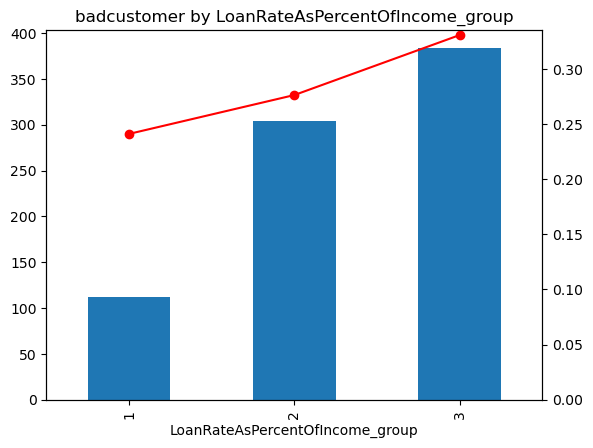

In [459]:
# plot the new bivariate charts with the newly created groups
fea=['loadAmount_group', 'loanDur_group', 'age_group', 'PurposeOfLoan', 'LoanRateAsPercentOfIncome_group']

for i in fea:
    bi_variate(x_train, i, 'badcustomer')

In [282]:
# WOE calculation for the categorical variable

def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# show WOE for puroseof loan feature
woe_discrete(x_train, 'PurposeOfLoan', x_train['GoodCustomer'])
# based on the WOE of the loan purpose feature, we should do the following:
# 1) group Furniture, Repairs, Business together because they have similar WOE, also, we should group Home Appliance
# with furniture because from domain knowledge, these two categories are very close. Also, home appliance is only 
# 1% of the records, too small
# 2) retraining has very few records, we would group it with Used car as they have similar WOE
# 3) group new car and Education together as they have similar WOE
# 4) we will leave Other as it is since it has very high bad rate and very different WOE compare to others


,PurposeOfLoan,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Other,9,0.555556,0.01125,5.0,4.0,0.008897,0.016807,-0.636088,NaN,NaN,0.138404
1,NewCar,191,0.617801,0.23875,118.0,73.0,0.209964,0.306723,-0.379006,0.062245,0.257082,0.138404
2,Education,38,0.631579,0.04750,24.0,14.0,0.042705,0.058824,-0.320235,0.013778,0.058771,0.138404
3,Furniture,135,0.666667,0.16875,90.0,45.0,0.160142,0.189076,-0.166084,0.035088,0.154151,0.138404
4,Repairs,18,0.666667,0.02250,12.0,6.0,0.021352,0.025210,-0.166084,0.000000,0.000000,0.138404
5,Business,81,0.679012,0.10125,55.0,26.0,0.097865,0.109244,-0.109995,0.012346,0.056089,0.138404
6,HomeAppliances,10,0.700000,0.01250,7.0,3.0,0.012456,0.012605,-0.011933,0.020988,0.098061,0.138404
7,Electronics,230,0.773913,0.28750,178.0,52.0,0.316726,0.218487,0.371309,0.073913,0.383242,0.138404
8,UsedCar,82,0.829268,0.10250,68.0,14.0,0.120996,0.058824,0.721219,0.055355,0.349911,0.138404
9,Retraining,6,0.833333,0.00750,5.0,1.0,0.008897,0.004202,0.750207,0.004065,0.028988,0.138404


In [283]:
# show woe for number of other loans feature. IV is very low
woe_discrete(x_train, 'NumberOfOtherLoansAtBank', x_train['GoodCustomer'])

,NumberOfOtherLoansAtBank,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,4,5,0.600000,0.00625,3.0,2.0,0.005338,0.008403,-0.453766,NaN,NaN,0.009604
1,1,509,0.693517,0.63625,353.0,156.0,0.628114,0.655462,-0.042619,0.093517,0.411147,0.009604
2,2,262,0.713740,0.32750,187.0,75.0,0.332740,0.315126,0.054389,0.020224,0.097008,0.009604
3,3,24,0.791667,0.03000,19.0,5.0,0.033808,0.021008,0.475770,0.077926,0.421381,0.009604


In [460]:
# WOE for loan rate percent feature
woe_discrete(x_train, 'LoanRateAsPercentOfIncome_group', x_train['GoodCustomer'])

,LoanRateAsPercentOfIncome_group,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,3,384,0.669271,0.48,257.0,127.0,0.457295,0.533613,-0.154342,NaN,NaN,0.026639
1,2,304,0.723684,0.38,220.0,84.0,0.391459,0.352941,0.103580,0.054413,0.257922,0.026639
2,1,112,0.758929,0.14,85.0,27.0,0.151246,0.113445,0.287583,0.035244,0.184004,0.026639


In [284]:
# create new binning for number of other loans
def numberofotherloans_group(x):
    if x>=3:
        return 3
    else:
        return x
x_train['NumberOfOtherLoansAtBank']=x_train['NumberOfOtherLoansAtBank'].apply(numberofotherloans_group)
x_test['NumberOfOtherLoansAtBank']=x_test['NumberOfOtherLoansAtBank'].apply(numberofotherloans_group)

# check the WOE monotonicity
woe_discrete(x_train, 'NumberOfOtherLoansAtBank', x_train['GoodCustomer'])

,NumberOfOtherLoansAtBank,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,509,0.693517,0.63625,353.0,156.0,0.628114,0.655462,-0.042619,NaN,NaN,0.004907
1,2,262,0.713740,0.32750,187.0,75.0,0.332740,0.315126,0.054389,0.020224,0.097008,0.004907
2,3,29,0.758621,0.03625,22.0,7.0,0.039146,0.029412,0.285901,0.044880,0.231512,0.004907


In [285]:
# create new category for purpose of loan by combining based on WOE

x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('Furniture', 'Furn|Rep|HomeApp|buss')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('Repairs', 'Furn|Rep|HomeApp|buss')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('HomeAppliances', 'Furn|Rep|HomeApp|buss')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('Business', 'Furn|Rep|HomeApp|buss')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('Retraining', 'Retrain|UsedC')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('UsedCar', 'Retrain|UsedC')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('NewCar', 'NewC|Ed')
x_train['PurposeOfLoan']=x_train['PurposeOfLoan'].str.replace('Education', 'NewC|Ed')


In [286]:
# create new category for purpose of loan by combining based on WOE
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('Furniture', 'Furn|Rep|HomeApp|buss')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('Repairs', 'Furn|Rep|HomeApp|buss')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('HomeAppliances', 'Furn|Rep|HomeApp|buss')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('Business', 'Furn|Rep|HomeApp|buss')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('Retraining', 'Retrain|UsedC')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('UsedCar', 'Retrain|UsedC')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('NewCar', 'NewC|Ed')
x_test['PurposeOfLoan']=x_test['PurposeOfLoan'].str.replace('Education', 'NewC|Ed')

In [287]:
# check the updated WOE and see that the groups are more distinct now.
woe_discrete(x_train, 'PurposeOfLoan', x_train['GoodCustomer'])

,PurposeOfLoan,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Other,9,0.555556,0.01125,5.0,4.0,0.008897,0.016807,-0.636088,NaN,NaN,0.137819
1,NewC|Ed,229,0.620087,0.28625,142.0,87.0,0.252669,0.365546,-0.369312,0.064532,0.266775,0.137819
2,Furn|Rep|HomeApp|buss,244,0.672131,0.30500,164.0,80.0,0.291815,0.336134,-0.141391,0.052044,0.227921,0.137819
3,Electronics,230,0.773913,0.28750,178.0,52.0,0.316726,0.218487,0.371309,0.101782,0.512700,0.137819
4,Retrain|UsedC,88,0.829545,0.11000,73.0,15.0,0.129893,0.063025,0.723178,0.055632,0.351869,0.137819


In [174]:
# check if the age group WOE is monotonic
woe_ordered_continuous (x_train, 'age_group', x_train['GoodCustomer'])


,age_group,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,303,0.633663,0.37875,192.0,111.0,0.341637,0.466387,-0.311266,NaN,NaN,0.065038
1,2,497,0.744467,0.62125,370.0,127.0,0.658363,0.533613,0.210085,0.110803,0.521351,0.065038


In [177]:
# check if the loan duration group WOE is monotonic
woe_ordered_continuous (x_train, 'loanDur_group', x_train['GoodCustomer'])

,loanDur_group,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,280,0.789286,0.35000,221.0,59.0,0.393238,0.247899,0.461394,NaN,NaN,0.140396
1,2,335,0.695522,0.41875,233.0,102.0,0.414591,0.428571,-0.033166,0.093763,0.494560,0.140396
2,3,115,0.608696,0.14375,70.0,45.0,0.124555,0.189076,-0.417398,0.086827,0.384233,0.140396
3,4,70,0.542857,0.08750,38.0,32.0,0.067616,0.134454,-0.687381,0.065839,0.269982,0.140396


In [179]:
# check if the loan amount group WOE is monotonic
woe_ordered_continuous (x_train, 'loanamount_group', x_train['GoodCustomer'])

,loanamount_group,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,490,0.726531,0.61250,356.0,134.0,0.633452,0.563025,0.117860,NaN,NaN,0.065791
1,2,157,0.713376,0.19625,112.0,45.0,0.199288,0.189076,0.052605,0.013155,0.065255,0.065791
2,3,68,0.705882,0.08500,48.0,20.0,0.085409,0.084034,0.016238,0.007493,0.036368,0.065791
3,4,85,0.541176,0.10625,46.0,39.0,0.081851,0.163866,-0.694151,0.164706,0.710389,0.065791


In [288]:


# apply to our final four categorical variables
x_train_dummy = pd.get_dummies(x_train['PurposeOfLoan'], drop_first=True)
x_train = pd.concat([x_train, x_train_dummy], axis = 1)
# update the test data with all functions defined so far

x_test_dummy = pd.get_dummies(x_test['PurposeOfLoan'], drop_first=True)
x_test = pd.concat([x_test, x_test_dummy], axis = 1)



In [289]:
x_train.head()

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,badcustomer,age_group,loanDur_group,loadAmount_group,loanamount_group,Furn|Rep|HomeApp|buss,NewC|Ed,Other,Retrain|UsedC
188,0,M,0,0,20,12,Electronics,674,4,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,0,0,0
194,0,M,0,1,21,45,Electronics,3031,4,4,1,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,4,6,2,0,0,0,0
225,1,M,0,1,27,36,Furn|Rep|HomeApp|buss,2613,4,2,2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,3,5,1,1,0,0,0
580,0,M,0,1,30,18,NewC|Ed,1056,3,3,2,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,2,2,1,1,0,1,0,0
428,1,M,0,1,20,9,Furn|Rep|HomeApp|buss,1313,1,4,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,2,1,1,0,0,0


In [290]:
# create the feature set and check for VIF
final_feature= [ 'ForeignWorker', 'Single', 
       'LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
       'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse',
       'RentsHouse', 'Unemployed', 'YearsAtCurrentJob_lt_1',
       'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled', 
       'age_group', 'loanDur_group',  'loanamount_group',
       'Furn|Rep|HomeApp|buss', 'NewC|Ed', 'Other', 'Retrain|UsedC']
 

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = x_train[final_feature].columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(x_train[final_feature].values, i) 
                            for i in range(len(x_train[final_feature].columns))]

In [291]:
# check VIF score to see if there are any >10 for multicolinearity
# age_group, NumberOfLiableIndividuals, MissedPayments have high VIF, we should drop them

vif_scores

,Attribute,VIF Scores
0,ForeignWorker,1.125698
1,Single,2.967362
2,LoanRateAsPercentOfIncome,9.197363
3,YearsAtCurrentHome,8.520442
4,NumberOfOtherLoansAtBank,9.925749
5,NumberOfLiableIndividuals,12.153049
6,HasTelephone,1.998531
7,CheckingAccountBalance_geq_0,1.832231
8,CheckingAccountBalance_geq_200,1.283666
9,SavingsAccountBalance_geq_100,2.329849


In [292]:
# check corr pairs of all features
x_train[final_feature].corr().unstack().sort_values().drop_duplicates()

RentsHouse                       OwnsHouse                         -7.312047e-01
Furn|Rep|HomeApp|buss            NewC|Ed                           -4.195244e-01
YearsAtCurrentJob_lt_1           YearsAtCurrentJob_geq_4           -3.908086e-01
loanamount_group                 LoanRateAsPercentOfIncome         -2.783461e-01
OwnsHouse                        YearsAtCurrentHome                -2.754967e-01
RentsHouse                       age_group                         -2.606914e-01
Furn|Rep|HomeApp|buss            Retrain|UsedC                     -2.328943e-01
NewC|Ed                          Retrain|UsedC                     -2.226389e-01
Single                           YearsAtCurrentJob_lt_1            -2.175242e-01
Unemployed                       YearsAtCurrentJob_geq_4           -2.172062e-01
YearsAtCurrentJob_lt_1           age_group                         -2.059692e-01
Single                           RentsHouse                        -1.974033e-01
YearsAtCurrentHome          

In [461]:

# create final features used in the model after dropping low value and high VIF features
final_feature=[ 'ForeignWorker', 'Single', 
       'LoanRateAsPercentOfIncome_group', 
       'NumberOfOtherLoansAtBank',  'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
        'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'HasCoapplicant',  'OwnsHouse',
       'RentsHouse',  'YearsAtCurrentJob_lt_1',
       'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled', 
        'loanDur_group',  'loanamount_group',
       'Furn|Rep|HomeApp|buss', 'NewC|Ed', 'Other', 'Retrain|UsedC']

In [570]:

# test the model on 5 fold cross validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)

solver = ['liblinear']
C=[0.1, 0.5, 1, 5, 10, 20, 25, 30]
penalty=['l1', 'l2']

for i in C:
    for j in penalty:
        model = LogisticRegression(C= i, penalty=j, solver='liblinear')
        results = cross_val_score(model, x_train[final_feature], 
                                         x_train['badcustomer'], cv=kfold, scoring='f1')
        # Output the accuracy. Calculate the mean and std across all folds.
        print('model parembers of C and penalty:', i, j)
        print("F1: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

model parembers of C and penalty: 0.1 l1
F1: 1.693% (2.100%)
model parembers of C and penalty: 0.1 l2
F1: 22.837% (7.937%)
model parembers of C and penalty: 0.5 l1
F1: 35.235% (4.468%)
model parembers of C and penalty: 0.5 l2
F1: 38.383% (5.317%)
model parembers of C and penalty: 1 l1
F1: 37.646% (3.581%)
model parembers of C and penalty: 1 l2
F1: 40.269% (5.116%)
model parembers of C and penalty: 5 l1
F1: 39.657% (4.340%)
model parembers of C and penalty: 5 l2
F1: 41.656% (4.422%)
model parembers of C and penalty: 10 l1
F1: 40.912% (4.885%)
model parembers of C and penalty: 10 l2
F1: 40.536% (4.248%)
model parembers of C and penalty: 20 l1
F1: 40.343% (4.987%)
model parembers of C and penalty: 20 l2
F1: 40.912% (4.885%)
model parembers of C and penalty: 25 l1
F1: 40.343% (4.987%)
model parembers of C and penalty: 25 l2
F1: 40.792% (4.677%)
model parembers of C and penalty: 30 l1
F1: 40.227% (4.925%)
model parembers of C and penalty: 30 l2
F1: 40.343% (4.987%)


In [571]:
# test the model on 5 fold cross validation

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

# Fit on data

best_clf = clf.fit(x_train[final_feature], x_train['badcustomer'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [572]:
# best score
best_clf.best_score_

0.42345167465941846

In [573]:
# best hyperperameters
best_clf.best_params_

{'classifier': LogisticRegression(C=29.763514416313132, penalty='l1', solver='liblinear'),
 'classifier__C': 29.763514416313132,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [574]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.
param_grid = [

    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(50,201,50)),
     'classifier__max_depth' : list(range(3,5,1)),
    'classifier__max_features' : list(range(6,20,4))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5,  scoring='f1')

# Fit on data

best_clf = clf.fit(x_train[final_feature], x_train['badcustomer'])

In [575]:
# ouptut the best hyperparemeters
clf.best_params_

{'classifier': RandomForestClassifier(max_depth=4, max_features=18, n_estimators=150),
 'classifier__max_depth': 4,
 'classifier__max_features': 18,
 'classifier__n_estimators': 150}

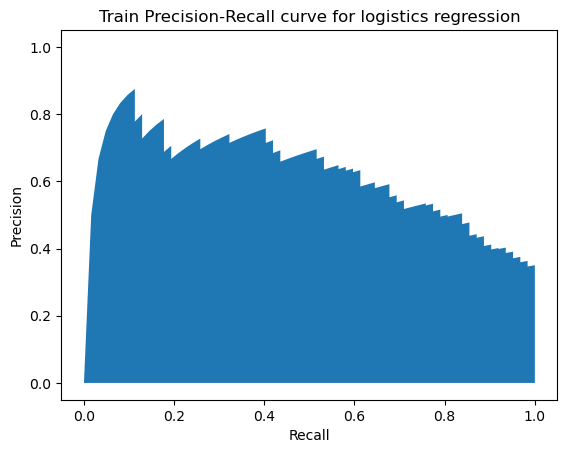

Logistics Regression PRAUC score is:  0.616383340626788


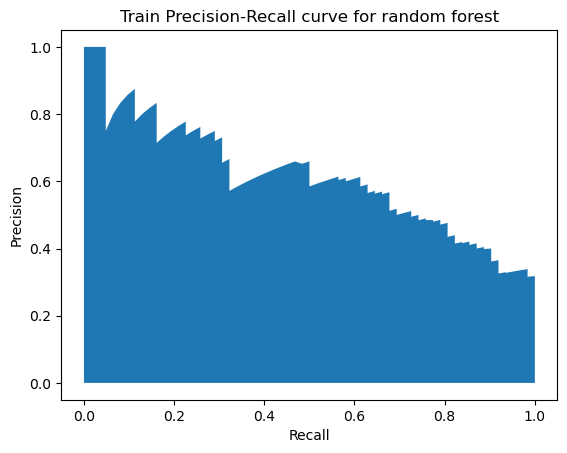

RF PRAUC score is:  0.6115413102927602


In [601]:
from sklearn.metrics import auc, plot_precision_recall_curve

# print PR and ROC curve for the logistics regression model

clf_l1_LR = LogisticRegression(C=29, penalty="l1",  solver="liblinear")
clf_l1_LR.fit(x_train[final_feature], x_train['badcustomer'])

#y_hat_test = clf_l1_LR.predict(x_test[final_feature])

x_test['pred_prob'] = clf_l1_LR.predict_proba(x_test[final_feature])[:][: , 1]

rf_model = RandomForestClassifier(n_estimators=50, max_features=18, max_depth=4)
# fit the model on the whole dataset
rf_model.fit(x_train[final_feature], x_train['badcustomer'])

x_test['pred_prob_rf'] = rf_model.predict_proba(x_test[final_feature])[:][: , 1]

#y_hat_test_proba
fpr, tpr, thresholds1 = roc_curve(x_test['badcustomer'], 
                                 x_test['pred_prob'])

precision, recall, thresholds = precision_recall_curve(x_test['badcustomer'], 
                                 x_test['pred_prob'])

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(x_test['badcustomer'], 
                                 x_test['pred_prob_rf'])

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve for logistics regression");

plt.show()
print ("Logistics Regression PRAUC score is: ", auc(recall, precision))

plt.fill_between(recall_rf, precision_rf)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve for random forest");

plt.show()
print ("RF PRAUC score is: ", auc(recall_rf, precision_rf))


# here is an example of plotting the ROC curve


AUROC: 0.7976


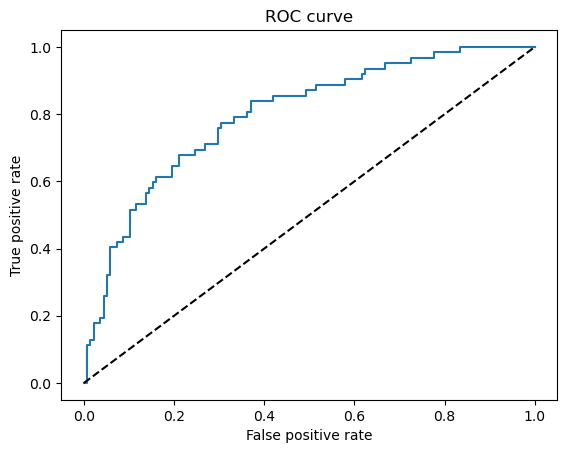

In [545]:
# example of the ROC curve, AUROC number for the logistics regression model
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(x_test['badcustomer'], x_test['pred_prob'])
# calculate Gini from AUROC

# print AUROC and Gini
print('AUROC: %.4f' % (AUROC))



In [546]:
# put the dataframe for the PR on logistics regression. From this, we can check the model score threshold
# and its corresponding precision recall
df_pr = pd.DataFrame({
    'precision': precision[:177],
    'recall': recall[:177],
    'thresholds': thresholds
})
df_pr

,precision,recall,thresholds
0,0.350282,1.000000,0.085448
1,0.346591,0.983871,0.086076
2,0.348571,0.983871,0.087064
3,0.350575,0.983871,0.087233
4,0.352601,0.983871,0.088981
5,0.354651,0.983871,0.089023
6,0.356725,0.983871,0.093736
7,0.358824,0.983871,0.094212
8,0.360947,0.983871,0.094492
9,0.363095,0.983871,0.097554


In [552]:
# put the dataframe for the PR on Random Forest regression. 
df_pr_rf = pd.DataFrame({
    'precision': precision_rf[:185],
    'recall': recall_rf[:185],
    'thresholds': thresholds_rf
    
})
df_pr_rf

,precision,recall,thresholds
0,0.328042,1.000000,0.110472
1,0.324468,0.983871,0.124673
2,0.320856,0.967742,0.126031
3,0.322581,0.967742,0.126236
4,0.324324,0.967742,0.127038
5,0.326087,0.967742,0.128496
6,0.327869,0.967742,0.129751
7,0.329670,0.967742,0.133136
8,0.331492,0.967742,0.133520
9,0.333333,0.967742,0.135143


In [642]:
# convert the probability of good customer to score card using points double odds method
# We choose to scale the points such that a total score of 600 points corresponds to good/bad odds 
# of 50 to 1 and an increase of the score of 20 points corresponds to a doubling of the good/bad odds.

prob_good=1-x_test['pred_prob']


#score from Siddiqi
pdo=20
factor=pdo/np.log(2)
offset=487 # this is 600 - 20/ln(2)*ln(50). We are using 600 points as a score for odds of 50 to 1

score=round(offset+factor*np.log(prob_good/(1-prob_good)),0)


<AxesSubplot:>

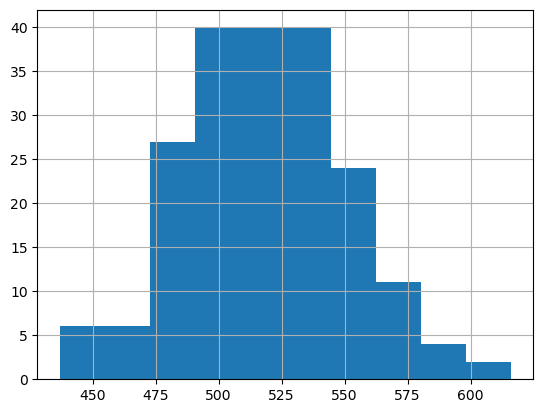

In [645]:
score.hist()

In [12]:

print ("hello world")


# build a chatbot, take in a sentence and learn which word will come out with each other, 
#generate any sentence that with length n from the corpos.
'''This is a sentence it is a great sentence
n = 4
choose first word at random:
it
it is
it is a
Ali Hussain1:10 PM
it is a sentence'''


hello world


In [15]:
# create a test program for sentence generation
s= 'This is a sentence it is a great sentence'

words=s.split()




['This', 'is', 'a', 'sentence', 'it', 'is', 'a', 'great', 'sentence']

In [49]:
word_freq = {}  # create an empty dictionary to store word frequency

for word in words:
    if word in word_freq:
        word_freq[word] += 1  # if the word is already in the dictionary, increase its count by 1
    else:
        word_freq[word] = 1  # if the word is not in the dictionary, add it with a count of 1

print("Word frequency count:\n")
for word, freq in word_freq.items():
    print(f"{word}: {freq}")  # print each word with its frequency

Word frequency count:

This: 1
is: 2
a: 2
sentence: 2
it: 1
great: 1


In [50]:
word_freq

{'This': 1, 'is': 2, 'a': 2, 'sentence': 2, 'it': 1, 'great': 1}

In [43]:
import re
from collections import defaultdict

def count_next_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    next_words = defaultdict(lambda: defaultdict(int))
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i+1]
        next_words[word][next_word] += 1
    return next_words

freq_dict= count_next_words(s)





In [60]:
dict_prob

{'this': {'is': 1.0},
 'is': {'a': 1.0},
 'a': {'sentence': 0.5, 'great': 0.5},
 'sentence': {'it': 1.0},
 'it': {'is': 1.0},
 'great': {'sentence': 1.0}}

In [44]:
freq_dict



defaultdict(<function __main__.count_next_words.<locals>.<lambda>()>,
            {'this': defaultdict(int, {'is': 1}),
             'is': defaultdict(int, {'a': 2}),
             'a': defaultdict(int, {'sentence': 1, 'great': 1}),
             'sentence': defaultdict(int, {'it': 1}),
             'it': defaultdict(int, {'is': 1}),
             'great': defaultdict(int, {'sentence': 1})})

In [59]:
import random

def get_random_word(words, freq):
    total_freq = sum(freq[word] for word in words)
    rand_num = random.uniform(0, total_freq)
    
    freq_sum = 0
    for word in words:
        freq_sum += freq[word]
        if freq_sum >= rand_num:
            return word
        
        
first_word=get_random_word(words, word_freq)


'a'

In [ ]:
import re
from collections import defaultdict

def calculate_weight(frequencies):
    total_count = sum(frequencies.values())
    return {word: freq/total_count for word, freq in frequencies.items()}

def calculate_next_word_weights(text):
    words = re.findall(r'\b\w+\b', text.lower())
    next_words = defaultdict(lambda: defaultdict(int))
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i+1]
        next_words[word][next_word] += 1
    
    return {word: calculate_weight(freqs) for word, freqs in next_words.items()}


dict_prob= calculate_next_word_weights(s)

In [65]:


dict_prob['a']

max(dict_prob['a'].values())

0.5

In [74]:
dict_prob

{'this': {'is': 1.0},
 'is': {'a': 1.0},
 'a': {'sentence': 0.5, 'great': 0.5},
 'sentence': {'it': 1.0},
 'it': {'is': 1.0},
 'great': {'sentence': 1.0}}

In [73]:
{i for i in dict_prob['a'] if dict_prob['a'].values()==0.5}

TypeError: '>=' not supported between instances of 'dict_values' and 'float'

In [ ]:
import random

def get_random_word(words, weights):
    if not words:
        return None
    
    if len(words) == 1:
        return words[0]
    
    total_weight = sum(weights[word] for word in words)
    rand_num = random.uniform(0, total_weight)
    
    weight_sum = 0
    for word in words:
        weight_sum += weights[word]
        if weight_sum >= rand_num:
            return word
        
get_random_word